In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use("seaborn")
!cd ../src && make clean
!cd ../src && make
print('\x1b[1;30m'+ 'Done!!' +'\x1b[0m')
print('\x1b[1;30m'+ 'Required: pandas version >1.0.0' +'\x1b[0m')

rm -f *.o ejec
g++ *.cpp -o ejec 
Done!!
Required: pandas version >1.0.0


## Levantamos los datos y los procesamos

In [130]:
df = pd.read_csv("../mejores_sol_sin_dobles.csv")
df.sort_values(by="cities",axis=0,ascending=True,inplace=True,ignore_index=True)
#df.describe()
df[:75].describe()

,cities,bounds
count,75.000000,75.000000
mean,206.706667,37163.746667
std,181.665922,51246.516383
min,14.000000,426.000000
25%,76.000000,3621.000000
50%,144.000000,21294.000000
75%,272.000000,48320.500000
max,666.000000,294358.000000


## Declaramos funciones importantes para la experimentación

In [127]:
import ast
#Llama al binario "ejec" con los parámetros pasados, toma filename en vez del path!!!
#Retorna una lista donde [0]=cant_vectores [1]=costo_solución [2]=tiempo insumido y [3]=array_camino
def llamarbin(mode, instance_name, tam=0, iter=0, percent_vecinos=0):
    file=to_path(instance_name)
    #print("{} {} {} {} {}".format(mode, file, tam, iter, percent_vecinos))
    #Llamo el binario desde la consola y guardo la salida en una variable
    output = !../src/ejec {mode} {file} {tam} {iter} {percent_vecinos}
    #Voy a devolver una lista donde [0]=cant_vectores [1]=costo_solución y [2]=array_camino
    l = ast.literal_eval(output[1])
    l = np.array(l, dtype=np.intc)
    man_out = output[0].split(' ', 2)
    man_out.append(l)
    #print(man_out)
    return man_out

#Transforma el rawname de una instancia a path de archivo
def to_path(instancia):
    res = "../data/" + instancia + ".tsp"
    return res

def removeOutliers(x :np.ndarray, outlierConstant=1.5):
    a = x
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    indexes = np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))
    result = a[indexes]
    
    return [result,indexes]

#Corre el binario para la lista de conjuntos de instancias instance_list, cada una con los modos de la lista de modos,
#para las primeras :size instancias de cada conjunto de instancias, y devuelve una lista de porcentajes de la solucion
#óptima que representa la diferencia en cada solucion (no devuelve directamente el costo de la 
#solucion obtenida por cada corrida) 
def correrbinvarios(modos, instance_list, bounds_list, size):
    resultados = []
    for j in range(len(modos)):
        lista = instance_list[j]
        bounds = bounds_list[j]
        mode = modos[j]

        costos_modo = np.empty(size)
        for i in range(size):
            print(i)
            res = llamarbin(mode,lista[i])
            #print(res)
            costos_modo[i]= res[1]
            #print(res[1])
            #print("modo ",mode,lista[i],": ",res[1])
            #print("bound:",bounds[i])
        #print(costos_modo)
        #print(bounds_list)
        #print(size)
        #print(bounds[:size])
        diff_costos= (costos_modo - bounds[:size])*100/(bounds[:size])
        #print(diff_costos)
        #print(removeOutliers(diff_costos)[1])
        resultados.append(diff_costos)
    #print("Soy resultados: ",resultados)
    return resultados

def correrbinconjunto(mode, lista, size, args):
    #print("{} {} {} {}".format(mode,size,args,lista))
    bounds = np.empty(size)
    costos_modo = np.empty(size)
    for i in range(size):
        res = llamarbin(mode,lista[i],args[0],args[1],args[2])
        costos_modo[i]= res[1]
        #print(lista[i],": ",res[1])
    #diff_costos= (bounds-costos_modo)*100/(bounds)
    return costos_modo

# Comparación general de la calidad de solución de las heurísticas
### Para instancias sin características particulares, tomadas de las instancias de la cátedra

In [228]:
#Generamos las instancias para este test
!cd ../data/dataGenerada && rm -rf ./*
!cd ../data/dataGenerada
!../src/ejec Random 50 100 1 30
comp_random = !cd ../data/dataGenerada && ls *.tsp
comp_random = ["dataGenerada/" + s[:-4] for s in comp_random]
print("Generadas las instancias random para el exp de comparación")

Generadas las instancias random para el exp de comparación


In [229]:
instance_list = comp_random
#bounds_list = [euc_bounds_list_2, no_euc_bounds_list]
cant_instancias_a_usar = 30

bounds_list_comp = []
for i in range(5):
    bounds = []
    bounds.append(correrbinconjunto("NN", instance_list, cant_instancias_a_usar, [0,0,0]))
    if(i==0):
        bounds_list_comp.append(bounds[0])
    else:
        #print("Blist : ",bounds_list_comp)
        #print("Bounds: ",bounds)
        bounds_list_comp[0] = np.minimum(bounds_list_comp[0],bounds[0])
bounds_list_comp = bounds_list_comp[0]
bounds_list_comp = [bounds_list_comp,bounds_list_comp,bounds_list_comp]
print("Calculados los mínimos valores conocidos")

Calculados los mínimos valores conocidos


In [254]:
instance_list_comp = [comp_random,comp_random,comp_random]
cant_instancias_a_usar = 30
modos = ["AGM","AMC","NN"]

costs_comp = []

promedios = [[],[],[]]
for i in range(5):
    corridas = []
    corridas = correrbinvarios(modos, instance_list_comp, bounds_list_comp, cant_instancias_a_usar)
    #corridas = np.mean(corridas,axis=1)
    promedios[0].append(corridas[0])
    promedios[1].append(corridas[1])
    promedios[2].append(corridas[2])
print(np.mean(promedios[0], axis=0))
costs_comp.append(np.mean(promedios[0], axis=0))
costs_comp.append(np.mean(promedios[1], axis=0))
costs_comp.append(np.mean(promedios[2], axis=0))

#for i in range(len(costs)):
#    costs_comp[i] = removeOutliers(costs[i])[0]
    
print(costs_comp)

[291.14754098 320.34482759 277.59562842 303.97790055 298.39572193]
[array([291.14754098, 320.34482759, 277.59562842, 303.97790055,
       298.39572193]), array([ -2.29508197,  -2.4137931 , -26.66666667,   1.87845304,
        -1.28342246]), array([12.34972678,  8.73563218, 11.69398907, 12.37569061,  4.81283422])]


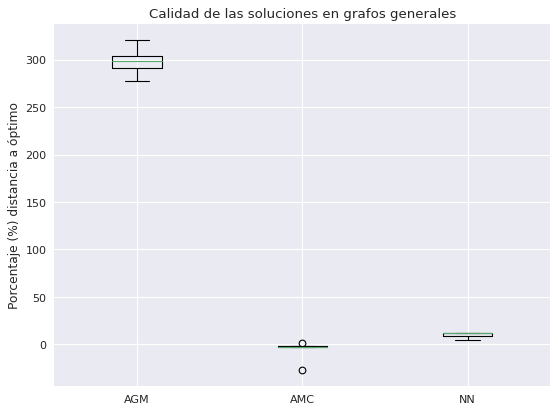

In [255]:
fig,ax=plt.subplots(1,1,figsize=(8,6),dpi=80)
ax.boxplot(costs_comp)
#ponerle legend y xticks y todo eso
locs,_ = plt.xticks()
plt.xticks(locs,modos)
plt.ylabel("Porcentaje (%) distancia a óptimo")
plt.title("Calidad de las soluciones en grafos generales");
fig.savefig("./graficos/calidad_comparacion.png")

# 1) AGM
## a) Calidad soluciones en grafos euclidianos vs no euclidianos

In [45]:
print("Cant. instancias euclideanas: {}, cant. instancias no euclideanas: {}".format(len(euc_list), len(no_euc_list)))

Cant. instancias euclideanas: 78, cant. instancias no euclideanas: 31


In [98]:
#Generamos las instancias para este test
!cd ../data/dataGenerada && rm -rf ./*
!cd ../data/dataGenerada && mkdir euc && mkdir no_euc
!../src/ejec Random 50 100 1 30
agm_no_euc = !cd ../data/dataGenerada && ls *.tsp
!cd ../data/dataGenerada && mv ./*.tsp ./no_euc
agm_no_euc = ["dataGenerada/no_euc/" + s[:-4] for s in agm_no_euc]
print("Generadas las instancias no euclideas para AGM")

Generadas las instancias no euclideas para AGM


In [99]:
#RandomEuclideo randomEuclideo(stoi(cantidadArchivos), stoi(cantidadVertices), stoi(nStart), stoi(nEnd));
#Generamos las instancias para este test
!../src/ejec RandomEuclideo 50 100 1 30
#agm_euc = !cd ../download_data/temp && ls *.tsp
#!../2_parsear_instancias_euclidianas_propias.sh
agm_euc = !cd ../data/dataGenerada/euc && ls *.tsp
agm_euc = ["dataGenerada/euc/" + s[:-4] for s in agm_euc]
print("Generadas las instancias euclideas para AGM")

mkdir: cannot create directory ‘data’: File exists
Generadas las instancias euclideas para AGM


Calculados los mínimos valores conocidos
[array([13.18681319, 17.24907063, 14.7985348 ]), array([242.24719101, 252.10526316, 257.65957447, 318.75706215,
       232.05882353])]


<Figure size 640x480 with 0 Axes>

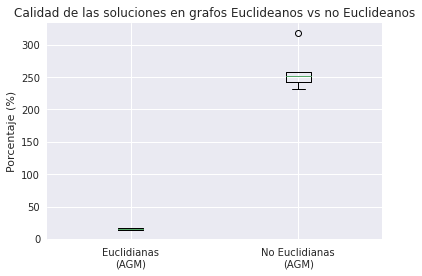

In [125]:
#modos = ["AGM","AMC","NN","TSU","TSA"]
modos = ["NN","NN","AGM","AGM"]
costs = []
fig=plt.figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots()

#euc_list_2 = np.concatenate((euc_list[:10],euc_list[40:]))
#euc_bounds_list_2 = np.concatenate((euc_bounds_list[:10], euc_bounds_list[40:]))
#euc_size_list_2 = np.concatenate((euc_size_list[:10], euc_size_list[40:]))

instance_list = [agm_euc, agm_no_euc]
#bounds_list = [euc_bounds_list_2, no_euc_bounds_list]
cant_instancias_a_usar = 50

bounds_list = []
for i in range(5):
    bounds = []
    bounds.append(correrbinconjunto(modos[0], instance_list[0], cant_instancias_a_usar, [0,0,0]))
    bounds.append(correrbinconjunto(modos[0], instance_list[1], cant_instancias_a_usar, [0,0,0]))
    if(i==0):
        bounds_list.append(bounds[0])
        bounds_list.append(bounds[1])
    else:
        #print(bounds)
        #print(bounds_list)
        bounds_list[0] = np.minimum(bounds_list[0],bounds[0])
        bounds_list[1] = np.minimum(bounds_list[1],bounds[1])
print("Calculados los mínimos valores conocidos")

promedios = [[],[]]
error = []
for i in range(5):
    corridasNN = []
    correrbinvarios(corridasNN, modos[2:], instance_list, bounds_list, cant_instancias_a_usar)
    promedios[0].append(corridasNN[0])
    promedios[1].append(corridasNN[1])

costs.append(np.mean(promedios[0], axis=0))
costs.append(np.mean(promedios[1], axis=0))

for i in range(len(costs)):
    costs[i] = removeOutliers(costs[i])[0]
    
print(costs)
ax.boxplot(costs)
#ponerle legend y xticks y todo eso
locs,_ = plt.xticks()
plt.xticks(locs,["Euclidianas\n(AGM)", "No Euclidianas\n(AGM)","Euclidianas\n(NN)", "No Euclidianas\n(NN)"])
plt.ylabel("Porcentaje (%)")
plt.title("Calidad de las soluciones en grafos Euclideanos vs no Euclideanos");
fig.savefig("./graficos/calidad_euclideano.png")

# Casos patológicos AMC y NN
### Generamos las instancias:

In [87]:
#Generamos las instancias para este test
!cd ../data/dataGenerada && rm -rf ./*
for i in range(1,31):
    number = str(i*5)
    !../src/ejec RandomNN 1 {number}
amc = !cd ../data/dataGenerada && ls
amc = ["dataGenerada/" + s[:-4] for s in amc]

print("Generadas las instancias patologicas para AMC")

mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File exists
mkdir: cannot create directory ‘../data/dataGenerada’: File ex

In [88]:
instance_list = amc
#bounds_list = [euc_bounds_list_2, no_euc_bounds_list]
cant_instancias_a_usar = 30

bounds_list_worst = []
for i in range(5):
    bounds = []
    bounds.append(correrbinconjunto("Falsa", instance_list, cant_instancias_a_usar, [0,0,0]))
    if(i==0):
        bounds_list_worst.append(bounds[0])
    else:
        #print("Blist : ",bounds_list_worst)
        #print("Bounds: ",bounds)
        bounds_list_worst[0] = np.minimum(bounds_list_worst[0],bounds[0])
bounds_list_worst = bounds_list_worst[0]
bounds_list_worst = [bounds_list_worst]
print("Calculados los mínimos valores conocidos")

Calculados los mínimos valores conocidos


## AMC

In [122]:
instance_list_worst = [amc]
cant_instancias_a_usar = 30
modos = ["AMC"]
cantCorridas = 5
costs_worst = []
tamanios_worst = list(range(0,151,5)) 
promedios = [[]]
for i in range(cantCorridas):
    print("Corrida:",i)
    corridas = []
    corridas = correrbinvarios(modos, instance_list_worst, bounds_list_worst, cant_instancias_a_usar)
    #corridas = np.mean(corridas,axis=1)
    promedios[0].append(corridas[0])
    #promedios[1].append(corridas[1])
    
#print(np.mean(promedios[0], axis=0))
costs_worst.append(np.mean(promedios[0], axis=0))
#costs_worst.append(np.mean(promedios[1], axis=0))

#for i in range(len(costs_worst)):
prom_worst = np.mean(costs_worst,axis=0)
err_worst = np.std(costs_worst,axis=0)

#for i in range(len(costs)):
#    costs_worst[i] = removeOutliers(costs[i])[0]
    
print(costs_worst)

Corrida: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Corrida: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Corrida: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Corrida: 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Corrida: 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[array([166.66666667, 199.65698144, 199.68898646, 199.71671388,
       199.74089316, 199.76210467, 199.78081485, 199.79740198,
       199.81217545, 199.8253903 , 199.83725828, 184.68468468,
       199.84795635, 191.32653061, 194.44444444, 196.14512472,
       197.17138103, 197.83715013, 198.29317269,  93.75      ,
       198.61900894, 198.85982562, 199.04279279, 199.18504314,
       199.29781082, 199.3887091 , 199.46304485, 199.5246085 ,
       199.57616554, 199.61977186])]


In [123]:
print(tam_g)
print(prom_worst)
print(err_worst)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
[166.66666667 199.65698144 199.68898646 199.71671388 199.74089316
 199.76210467 199.78081485 199.79740198 199.81217545 199.8253903
 199.83725828 184.68468468 199.84795635 191.32653061 194.44444444
 196.14512472 197.17138103 197.83715013 198.29317269  93.75
 198.61900894 198.85982562 199.04279279 199.18504314 199.29781082
 199.3887091  199.46304485 199.5246085  199.57616554 199.61977186]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
[166.66666667 199.65698144 199.68898646 199.71671388 199.74089316
 199.76210467 199.78081485 199.79740198 199.81217545 199.8253903
 199.83725828 184.68468468 199.84795635 191.32653061 194.44444444
 196.14512472 197.17138103 197.83715013 198.29317269  93.75
 198.61900894 198.85982562 199.04279279 199.18504314 199.29781082
 199.3887091  199.46304485 199.5246085  199.57616554 199.61977186]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


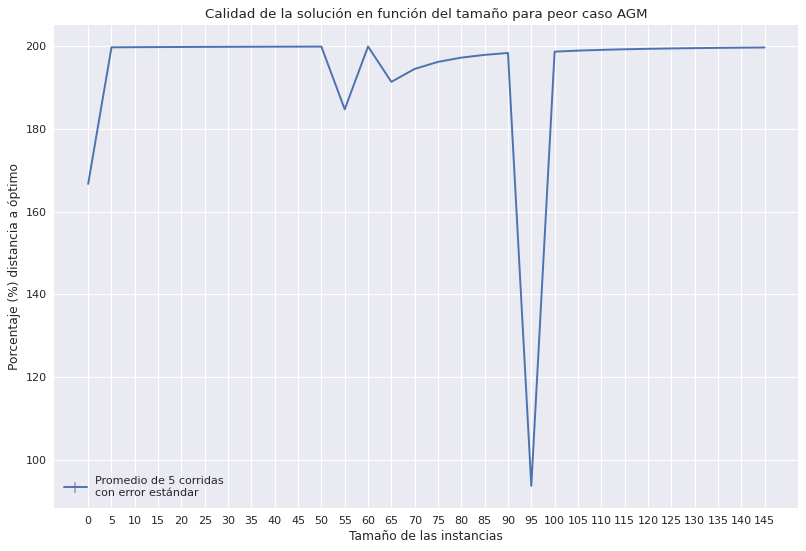

In [124]:
#print(calidadPorTamanio)
#err_worst_2 = [err_worst[i]/np.sqrt(np.shape(promedios[i]))[0] for i in range(len(err_worst))]

fig,(ax1)=plt.subplots(1,1,figsize=(12, 8), dpi=80)
tam_g = tamanios_worst[:30]
pro_g = prom_worst
err_g = err_worst

print(tam_g)
print(pro_g)
print(err_g)

plt.xticks(tam_g)
plt.ylabel("Porcentaje (%) distancia a óptimo")
plt.xlabel("Tamaño de las instancias")
plt.title("Calidad de la solución en función del tamaño para peor caso "+modos[0]);
_,caps,bars = ax1.errorbar(tam_g,pro_g,yerr=err_g)
[bar.set_alpha(0.5) for bar in bars]

# use them in the legend
ax1.legend(["Promedio de {} corridas \ncon error estándar".format(cantCorridas)])

fig.savefig("./graficos/worstCase"+str(modos[0])+".png")

## NN

In [122]:
instance_list_worst = [amc]
cant_instancias_a_usar = 30
modos = ["NN"]
cantCorridas = 5
costs_worst = []
tamanios_worst = list(range(0,151,5)) 
promedios = [[]]
for i in range(cantCorridas):
    print("Corrida:",i)
    corridas = []
    corridas = correrbinvarios(modos, instance_list_worst, bounds_list_worst, cant_instancias_a_usar)
    #corridas = np.mean(corridas,axis=1)
    promedios[0].append(corridas[0])
    #promedios[1].append(corridas[1])
    
#print(np.mean(promedios[0], axis=0))
costs_worst.append(np.mean(promedios[0], axis=0))
#costs_worst.append(np.mean(promedios[1], axis=0))

#for i in range(len(costs_worst)):
prom_worst = np.mean(costs_worst,axis=0)
err_worst = np.std(costs_worst,axis=0)

#for i in range(len(costs)):
#    costs_worst[i] = removeOutliers(costs[i])[0]
    
print(costs_worst)

Corrida: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Corrida: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Corrida: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Corrida: 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Corrida: 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[array([166.66666667, 199.65698144, 199.68898646, 199.71671388,
       199.74089316, 199.76210467, 199.78081485, 199.79740198,
       199.81217545, 199.8253903 , 199.83725828, 184.68468468,
       199.84795635, 191.32653061, 194.44444444, 196.14512472,
       197.17138103, 197.83715013, 198.29317269,  93.75      ,
       198.61900894, 198.85982562, 199.04279279, 199.18504314,
       199.29781082, 199.3887091 , 199.46304485, 199.5246085 ,
       199.57616554, 199.61977186])]


In [123]:
print(tam_g)
print(prom_worst)
print(err_worst)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
[166.66666667 199.65698144 199.68898646 199.71671388 199.74089316
 199.76210467 199.78081485 199.79740198 199.81217545 199.8253903
 199.83725828 184.68468468 199.84795635 191.32653061 194.44444444
 196.14512472 197.17138103 197.83715013 198.29317269  93.75
 198.61900894 198.85982562 199.04279279 199.18504314 199.29781082
 199.3887091  199.46304485 199.5246085  199.57616554 199.61977186]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
[166.66666667 199.65698144 199.68898646 199.71671388 199.74089316
 199.76210467 199.78081485 199.79740198 199.81217545 199.8253903
 199.83725828 184.68468468 199.84795635 191.32653061 194.44444444
 196.14512472 197.17138103 197.83715013 198.29317269  93.75
 198.61900894 198.85982562 199.04279279 199.18504314 199.29781082
 199.3887091  199.46304485 199.5246085  199.57616554 199.61977186]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


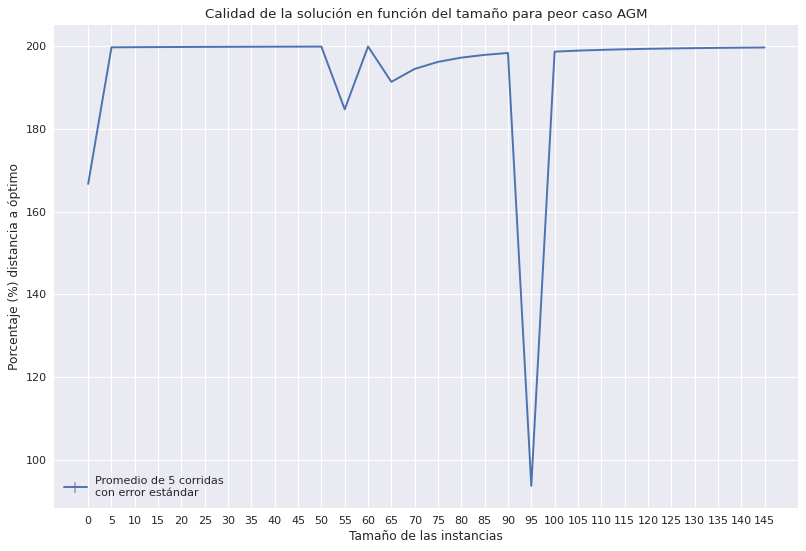

In [124]:
#print(calidadPorTamanio)
#err_worst_2 = [err_worst[i]/np.sqrt(np.shape(promedios[i]))[0] for i in range(len(err_worst))]

fig,(ax1)=plt.subplots(1,1,figsize=(12, 8), dpi=80)
tam_g = tamanios_worst[:30]
pro_g = prom_worst
err_g = err_worst

print(tam_g)
print(pro_g)
print(err_g)

plt.xticks(tam_g)
plt.ylabel("Porcentaje (%) distancia a óptimo")
plt.xlabel("Tamaño de las instancias")
plt.title("Calidad de la solución en función del tamaño para peor caso "+modos[0]);
_,caps,bars = ax1.errorbar(tam_g,pro_g,yerr=err_g)
[bar.set_alpha(0.5) for bar in bars]

# use them in the legend
ax1.legend(["Promedio de {} corridas \ncon error estándar".format(cantCorridas)])

fig.savefig("./graficos/worstCase"+str(modos[0])+".png")